In [237]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [238]:
import torch
from torch.utils.data import DataLoader, TensorDataset

import pytorch_lightning as pl

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold

from db.db import init_db, get_stocks

from model.predictor import LitLSTMModel

from helpers.plots import data_plot

from tickers import TICKERS

In [239]:
await init_db()

In [240]:

df = await get_stocks(TICKERS[:3])
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 25827 entries, 1990-01-02 to 2024-03-05
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  25827 non-null  object 
 1   open    23538 non-null  float64
 2   high    23538 non-null  float64
 3   low     23538 non-null  float64
 4   close   23538 non-null  float64
 5   volume  23538 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.4+ MB


,symbol,open,high,low,close,volume
2024-02-28,NVDA,776.163594,789.292983,771.213814,776.593567,39311000.0
2024-02-29,NVDA,790.902902,799.862503,783.463248,791.082886,50728900.0
2024-03-01,NVDA,799.962494,822.961416,794.312735,822.751404,47677700.0
2024-03-04,NVDA,841.260529,876.908881,837.150736,852.330017,61561600.0
2024-03-05,NVDA,852.700012,860.969971,834.169983,859.640015,51770200.0


In [241]:
# Adjust the data so the columns are {symbol}_open and the date as index
pivot_df = df.pivot(columns='symbol', values='open')
pivot_df.index = pd.to_datetime(pivot_df.index)

# Drop all the columns with no values and print the ones that were dropped
pivot_df.dropna(axis=1, how='all', inplace=True)

# Get the weekend data as well
pivot_df = pivot_df.asfreq('D')

pivot_df.bfill(inplace=True)

pivot_df.info()
pivot_df.head(n=10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12482 entries, 1990-01-02 to 2024-03-05
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    12482 non-null  float64
 1   MSFT    12482 non-null  float64
 2   NVDA    12482 non-null  float64
dtypes: float64(3)
memory usage: 390.1 KB


symbol,AAPL,MSFT,NVDA
1990-01-02,0.248953,0.374945,0.40132
1990-01-03,0.268375,0.384613,0.40132
1990-01-04,0.270141,0.383539,0.40132
1990-01-05,0.266610,0.393208,0.40132
1990-01-06,0.264843,0.384614,0.40132
1990-01-07,0.264843,0.384614,0.40132
1990-01-08,0.264843,0.384614,0.40132
1990-01-09,0.268375,0.391059,0.40132
1990-01-10,0.265727,0.386762,0.40132
1990-01-11,0.256016,0.381390,0.40132


In [242]:
# data_plot(df)

In [243]:
train, test = train_test_split(pivot_df, test_size=0.2, shuffle=False)
print(train.shape, test.shape)

(9985, 3) (2497, 3)


In [244]:
# Scale the data per column
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.fit_transform(test)

# Convert back into the previous format
scaled_train_df = pd.DataFrame(scaled_train, columns=train.columns, index=train.index)
scaled_test_df = pd.DataFrame(scaled_test, columns=test.columns, index=test.index)

print(scaled_train_df.head())

symbol          AAPL      MSFT      NVDA
1990-01-02  0.004416  0.000144  0.002779
1990-01-03  0.004982  0.000296  0.002779
1990-01-04  0.005033  0.000279  0.002779
1990-01-05  0.004931  0.000431  0.002779
1990-01-06  0.004879  0.000296  0.002779


In [245]:
# Create a tensor of size window size for each sample
def create_sequences(X, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(X[i+1:i+window_size+1])
    return np.array(Xs), np.array(ys)

In [246]:
# Create sequences for the train data
seq_length = 50
X_train, y_train = create_sequences(scaled_train_df, window_size=seq_length)

# Convert to tensor
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

# Create sequences for the test data
seq_length = 30
X_test, y_test = create_sequences(scaled_test_df, window_size=seq_length)

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([9935, 50, 3]) torch.Size([9935, 50, 3])
torch.Size([2467, 30, 3]) torch.Size([2467, 30, 3])


In [247]:
# Define the model
input_size = X_train.shape[2]
num_layers = X_train.shape[1]
hidden_layer_size = 64

model = LitLSTMModel(input_size, input_size, hidden_layer_size, num_layers)
print(type(model))
trainer = pl.Trainer(limit_train_batches=100, max_epochs=10, min_epochs=3, gradient_clip_val=0.5, deterministic=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<class 'model.predictor.LitLSTMModel'>


In [248]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16, shuffle=False)

# Train the model
trainer.fit(model, train_loader, val_loader)


  | Name   | Type   | Params
----------------------------------
0 | lstm   | LSTM   | 50.9 K
1 | linear | Linear | 195   
----------------------------------
51.1 K    Trainable params
0         Non-trainable params
51.1 K    Total params
0.205     Total estimated model params size (MB)


/home/manuel/Projects/StockPredictor/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/manuel/Projects/StockPredictor/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 43.36it/s, v_num=42, train_loss=0.000173, val_loss=0.000431]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 43.22it/s, v_num=42, train_loss=0.000173, val_loss=0.000431]


In [268]:
# Define the number of future time steps to forecast
num_forecast_steps = 30

# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().cpu().numpy()

# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float()
        # Use the model to predict the next value
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

        # Append the predicted value to the forecasted_values list
        forecasted_values.append(predicted_value)

        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value[0]


# Generate futute dates
last_date = test.index[-1]

# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

# Concatenate the original index with the future dates
combined_index = test.index.append(future_dates)

In [270]:
# Reshape 60,1 into 30,3
np.array(forecasted_values).shape

(60, 3)

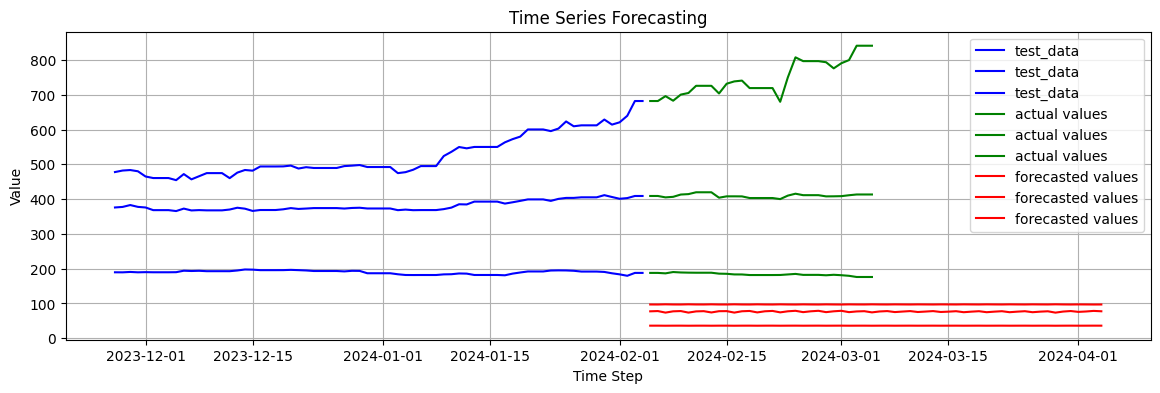

In [271]:
#set the size of the plot
plt.rcParams['figure.figsize'] = [14, 4]

#Test data
plt.plot(test.index[-100:-30], test.values[-100:-30], label = "test_data", color = "b")
#reverse the scaling transformation
original_cases = scaler.inverse_transform(sequence_to_plot[-1])
# original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten()

#the historical data used as input for forecasting
plt.plot(test.index[-30:], original_cases, label='actual values', color='green')

#Forecasted Values
#reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.array(forecasted_values))
# forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten()

# plotting the forecasted values
plt.plot(combined_index[-60:], forecasted_cases, label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)